# Loading data

In [0]:
from pyspark.sql.functions import input_file_name

df = (
    spark.read.option("delimiter", "|")
    .option("inferSchema", False)
    .csv("/mnt/2024-team21/Health-Tweets")
    .withColumn("filepath", input_file_name())
)

# cache the dataframe
# df.cache()

In [0]:
# Checking number of rows
num_rows = df.count()
print(num_rows)

63326


In [0]:
from pyspark.sql import functions as F

df = df.select("_c2")

# rename columns
df = df.withColumnRenamed("_c2", "tweet")
# df.show(10,truncate=False)

# Preprocessing

In [0]:
%pip install spacy
%pip install pandas

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
# dbutils.library.restartPython()

In [0]:
import spacy

# Check if en_core_web_lg is installed
try:
    nlp = spacy.load("en_core_web_lg")
except OSError as e:
    !python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.1 MB/s eta 0:00:00

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [0]:

#______________________________________________________________
# Load and broadcast spacy pretrained model for lemmatization
# import spacy
nlp = spacy.load("en_core_web_lg")
nlp_bc = sc.broadcast(nlp)
#______________________________________________________________

from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.feature import Tokenizer, StopWordsRemover


# Remove URL, Twitter handles, and numbers; remove punctuation marks; and trim whitespaces
df = df.withColumn(
    "tweet", F.regexp_replace(df["tweet"], "http\\S+|www.\\S+|@[\\w]+|\\d+", "")
)
# Replace multiple white spaces and tabs with a single whitespace
df = df.withColumn("tweet", F.regexp_replace(df["tweet"], "\\s+", " "))
df = df.withColumn("tweet", F.regexp_replace(df["tweet"], "[^a-zA-Z\\s{1,}]", ""))
df = df.withColumn("tweet", F.trim(df["tweet"]))

# remove empty rows if any and drop duplicates
df = df.filter(F.length(df.tweet) > 0)
df = df.drop_duplicates(subset=["tweet"])


# Tokenize the tweet,
tokenizer = Tokenizer(inputCol="tweet", outputCol="tokens")
df = tokenizer.transform(df)

sw_remover = StopWordsRemover(inputCol="tokens", outputCol="tokens2")
df = sw_remover.transform(df)

df = df.withColumn("tokens2", F.expr("filter(tokens2, t -> length(t) > 2)"))

# Lemmatize tweets
def lemmatize_word(tweet):
    return [nlp_bc.value(word)[0].lemma_ for word in tweet]


lemmatize_word_udf = udf(lemmatize_word, returnType=ArrayType(StringType()))

df = df.drop("tokens")
df = df.withColumnRenamed("tokens2", "tokens")

df = df.withColumn("tokens", lemmatize_word_udf(F.col("tokens")))

# cache the df, it will be reused from this point on
df.persist()

# Show the df here to ensure everything is okay, and make spark actually create it
df.show(5) # action


+--------------------+--------------------+
|               tweet|              tokens|
+--------------------+--------------------+
|creative and heal...|[creative, health...|
|Its easier to cop...|[easy, cope, anxi...|
|Stuck at your des...|[stick, desk, job...|
|Tell Us What tric...|[tell, trick, use...|
|Hilarious Holiday...|[hilarious, holid...|
+--------------------+--------------------+
only showing top 5 rows



In [0]:
# drop the broadcast variable to save memory, of course we are aware that spark has an internal mechanism to handle broacast variables, but doing this prioritizes it for garbage collection
nlp_bc = None

In [0]:
df = df.select('tokens')

### Sample data for labelling and training 
- because the dataset is small we take 50% to get enough training examples (around 30k)

In [0]:
sample_size = 0.5
df = df.withColumn("indicator", F.when(F.rand(seed=2024) <= sample_size, 1).otherwise(0))


In [0]:
## Sample the dataframe for labelling and training
df_sample = df.filter(df["indicator"] == 1)


In [0]:
# Get data without labels
df_nolabel = df.filter(df["indicator"] == 0)


In [0]:
# # Convert sample dataset to pandas for labelling
import pandas as pd

df_pd = df_sample.toPandas()
# df_pd.head()

In [0]:
%pip install nltk
%pip install bitermplus
%pip install tmplot
%pip install tomotopy
%pip install gensim
%pip install scipy

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.4/264.4 kB 7.2 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for bitermplus: filename=bitermplus-0.7.0-cp310-cp310-linux_x86_64.whl size=862697 sha256=9086d54fba061eccd94f998187aac232c33d378373e185e52a449043719057d2
  Stored in directory: /home/spark-3695364e-0dd4-48a3-88b9-20/.cache/pip/wheels/ad/ca/fc/678741496ee367fa4

In [0]:
# Prepare input for BitermTopic
def join_tokens(token_list):
    joined_tokens = " ".join(token_list)
    return joined_tokens


text = list(df_pd["tokens"].apply(join_tokens))

In [0]:
text

['creative healthy chicken recipe via',
 'easy cope anxiety realize come see surprising source stress',
 'see holiday diet hazard avoidand healthy option taste indulgent',
 'another study find vaccineautism link',
 'like share sign weekly newsletter celebrate health food amp nutrition',
 'gross people emit flu germ air foot away study find',
 'stay motivate put sneaker night they like pick I pick share trick use',
 'spread christmas cheer throughout household let kid help easytomake treat',
 'anyone vacation come here avoid pack pound',
 'foodiefriday froyo builtin portion control',
 'researcher conduct study cia psychologist cite say grieve horrify twisting work',
 'detergent pod pose risk child study find',
 'thought top dentist reflection fish eat letter reader',
 'salsas turn simple bbq quesadilla something spectacular',
 'business brief senator query hepatitis drug high cost',
 'realizedi need another checklist one put patient center',
 'well speak uncomfortable condition',
 'stud

In [0]:
import bitermplus as btm

X, vocabulary, vocab_dict = btm.get_words_freqs(text)

docs_vec = btm.get_vectorized_docs(text, vocabulary)
biterms = btm.get_biterms(docs_vec)

# Initializing and running model
model = btm.BTM(X, vocabulary, seed=2024, T=7, M=20, alpha=50 / 8, beta=0.01)
model.fit(biterms, iterations=50)

100%|██████████| 50/50 [00:02<00:00, 16.95it/s]


In [0]:
p_zd = model.transform(docs_vec)
p_zd

100%|██████████| 29679/29679 [00:00<00:00, 186117.94it/s]


array([[1.01220782e-02, 8.99391325e-01, 1.07290413e-02, ...,
        5.77502033e-02, 2.42463757e-03, 1.61877033e-02],
       [1.27909252e-01, 1.62439173e-01, 7.72308518e-02, ...,
        3.83359945e-01, 6.33575109e-03, 1.84722448e-01],
       [1.64856296e-02, 7.13601207e-01, 7.26216820e-03, ...,
        2.04041389e-01, 1.74191927e-02, 1.73595592e-02],
       ...,
       [2.95942643e-02, 4.72056478e-04, 8.19222332e-02, ...,
        3.68592161e-01, 1.24192542e-02, 2.72717521e-01],
       [2.14843855e-02, 6.26035355e-02, 1.12635301e-02, ...,
        8.34417813e-01, 1.71813319e-02, 3.35071614e-02],
       [7.57994662e-03, 5.72294664e-01, 1.48426550e-07, ...,
        4.11252036e-01, 1.65615995e-10, 7.99828778e-03]])

In [0]:
%pip install tmplot
%pip install gensim
%pip install tomotopy

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
# dbutils.library.restartPython()
import tmplot as tmp

# Run the interactive report interface
tmp.report(model=model, docs=text, height=500, width=100)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fc07088b250>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

### Labelling tweets
- Labelling is done on a sample (50%) of tweets taken from the 'big' dataset
- Topic modelling helped to discover some patterns in topics present in the tweets
- This was then complemented with word counts to select keywords for the identified topics
- Labelling was done based on the presence of keywords in a particular tweet

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

# Create a bag of words
bag_vectorizer = CountVectorizer(min_df=2)

# Fit and transform the preprocessed text
bag_matrix = bag_vectorizer.fit_transform(text)

In [0]:
# preview
sum_words = bag_matrix.sum(axis=0)
fnames = bag_vectorizer.get_feature_names_out()
fnames.shape
sum_words.shape


(1, 8772)

### Display hot keywords from the sample

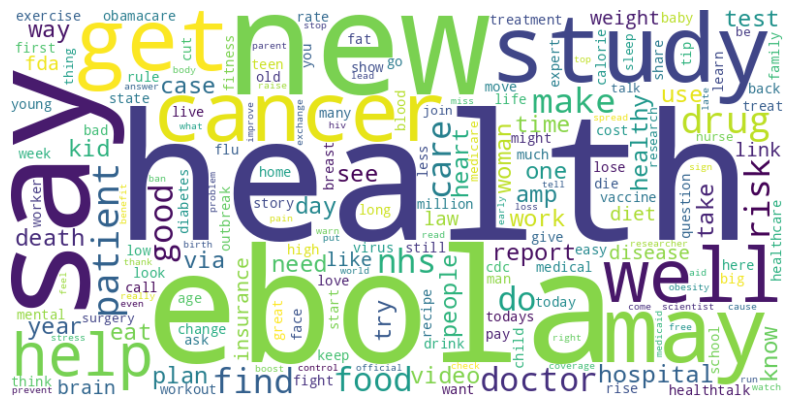

In [0]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Convert the bag matrix to a dictionary of word frequencies
word_freq_dict = {word: freq for word, freq in zip(fnames, sum_words.A[0])}

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

# Visualize the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('plots/wordCloud.png',bbox_inches='tight')
plt.show()

In [0]:
# word count
words_freq = [
    (word, sum_words[0, windex]) for word, windex in bag_vectorizer.vocabulary_.items()
]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

i = 20
num = 0
words_freq[num : num + i]


[('health', 2439),
 ('ebola', 1937),
 ('new', 1643),
 ('say', 1587),
 ('study', 1553),
 ('may', 1498),
 ('get', 1359),
 ('cancer', 1195),
 ('well', 1115),
 ('help', 1059),
 ('drug', 1057),
 ('patient', 1018),
 ('make', 930),
 ('find', 888),
 ('risk', 887),
 ('doctor', 822),
 ('care', 809),
 ('good', 805),
 ('nhs', 802),
 ('food', 796)]

In [0]:
# Creating labels based on keywords
classes = {
    "diagnosis and treatment": [
        "drug", "vaccine", "surgery", "treatment", "treat", "pharma", "therapy",
        "medicine", "transplant", "screening", "antibiotic", "diagnosis", "dna",
        "pharmalot", "genetic", "pharmalittle", "vaccination", "painkiller",
        "pharmacy"
    ],
    "food and nutrition": [
        "food", "recipe", "calorie", "eat", "eats", "fat", "eating", "meal", "sugar",
        "breakfast", "snack", "vitamin", "veggie", "coffee", "talknutrition",
        "nutrition", "pizza", "potato", "salad", "chocolate", "butter", "obese",
        "soda", "energy", "milk", "fish", "protein", "chocolate", "cholesterol",
        "meat", "restaurant", "salt", "vegetarian", "delicious", "pizza", "vegan",
        "cheese", "glutenfree", "apple", "overweight", "cooking", "dinner", "diet",
        "sweet", "chicken", "fruit"
    ],
    "fitness": [
        "weight", "exercise", "workout", "obesity", "fitness", "weightloss", "fit",
        "gym", "chocolate", "cholesterol", "sport", "marathon", "pound"
    ],
    "insurance": [
        "obamacare", "insurance", "insurer", "uninsured", "medicare", "medicaid",
        "underinsured"
    ],
    "diseases": [
        "ebola", "cancer", "flu", "hiv", "mental", "stress", "alzheimers", "smoking",
        "stroke", "autism", "measles", "disorder", "suicide", "drinking", "dementia",
        "hepatitis", "tobacco", "cigarette", "prostate", "aging", "bacteria",
        "meningitis", "concussion", "polio", "asthma", "hpv", "adhd", "elderly",
        "ecigarettes", "malaria", "psoriasis", "mentalhealth", "syndrome", "diabetes",
        "parkinson", "enterovirus", "mentally", "ill", "depression", "disease",
        "arthritis", "headache", "heart"
    ]  
}


In [0]:
# Functiuon to assign labels
def assign_class(text: list):
    for k in classes.keys():
        for w in classes[k]:
            if w in text:
                return k
    return "other"

In [0]:
# sassigning labels
df_pd["tweet2"] = df_pd["tokens"].apply(join_tokens)
df_pd["label"] = df_pd["tweet2"].apply(assign_class)

classes = df_pd["label"].value_counts()
classes

other                      11878
diseases                    6231
food and nutrition          5194
diagnosis and treatment     3420
fitness                     1702
insurance                   1254
Name: label, dtype: int64

In [0]:
# class distribution
class_distribution = classes / classes.sum()
class_distribution

other                      0.400216
diseases                   0.209946
food and nutrition         0.175006
diagnosis and treatment    0.115233
fitness                    0.057347
insurance                  0.042252
Name: label, dtype: float64

In [0]:
import pandas as pd

# Convert class distribution to a pandas DataFrame
class_distr = pd.DataFrame({'class':class_distribution.index, 'proportion':class_distribution*100}).reset_index(drop=True)
# export to latex
class_distr.to_latex('./distribution.tex', float_format='%.2f')



In [0]:
df_pd

,tokens,indicator,tweet2,label
0,"[creative, healthy, chicken, recipe, via]",1,creative healthy chicken recipe via,food and nutrition
1,"[easy, cope, anxiety, realize, come, see, surp...",1,easy cope anxiety realize come see surprising ...,diseases
2,"[see, holiday, diet, hazard, avoidand, healthy...",1,see holiday diet hazard avoidand healthy optio...,food and nutrition
3,"[another, study, find, vaccineautism, link]",1,another study find vaccineautism link,diagnosis and treatment
4,"[like, share, sign, weekly, newsletter, celebr...",1,like share sign weekly newsletter celebrate he...,food and nutrition
...,...,...,...,...
29674,"[new, pfizer, lilly, drug, target, protein, sh...",1,new pfizer lilly drug target protein show prom...,diagnosis and treatment
29675,"[enroll, health, care, law]",1,enroll health care law,other
29676,"[organize, caregiver, end, life, caregive]",1,organize caregiver end life caregive,other
29677,"[top, hour, join, healthtalk, well, chat, keep...",1,top hour join healthtalk well chat keep motiva...,other


In [0]:
# df_pd['tweet3'] = df_pd['tweet2'].apply(join_tokens)
df_pd[["tweet2", "label"]].tail()

,tweet2,label
29674,new pfizer lilly drug target protein show prom...,diagnosis and treatment
29675,enroll health care law,other
29676,organize caregiver end life caregive,other
29677,top hour join healthtalk well chat keep motiva...,other
29678,tip healthy eat dine healthtalk,food and nutrition


In [0]:
df_pd['indicator'] = 1
df_pd = df_pd[["tweet2", "tokens", "label", "indicator"]]
df_pd

,tweet2,tokens,label,indicator
0,creative healthy chicken recipe via,"[creative, healthy, chicken, recipe, via]",food and nutrition,1
1,easy cope anxiety realize come see surprising ...,"[easy, cope, anxiety, realize, come, see, surp...",diseases,1
2,see holiday diet hazard avoidand healthy optio...,"[see, holiday, diet, hazard, avoidand, healthy...",food and nutrition,1
3,another study find vaccineautism link,"[another, study, find, vaccineautism, link]",diagnosis and treatment,1
4,like share sign weekly newsletter celebrate he...,"[like, share, sign, weekly, newsletter, celebr...",food and nutrition,1
...,...,...,...,...
29674,new pfizer lilly drug target protein show prom...,"[new, pfizer, lilly, drug, target, protein, sh...",diagnosis and treatment,1
29675,enroll health care law,"[enroll, health, care, law]",other,1
29676,organize caregiver end life caregive,"[organize, caregiver, end, life, caregive]",other,1
29677,top hour join healthtalk well chat keep motiva...,"[top, hour, join, healthtalk, well, chat, keep...",other,1


## Train-Test Split
- The test set need to be labelled with correct labels, therefore taken from the labelled set.

In [0]:
# Split the dataset into training and test
# _pd suffix imply pandas
from sklearn.model_selection import train_test_split

df_train_pd, df_test_pd = train_test_split(
    df_pd, test_size=0.2, shuffle=True, stratify=df_pd["label"], random_state=2024
)

## Covert test set pandas dataframe to spark dataframe, will be used to evaluate the entire model
df_test = spark.createDataFrame(df_test_pd)

In [0]:
cols = df_train_pd.columns
cols

Index(['tweet2', 'tokens', 'label', 'indicator'], dtype='object')

## Use Training data to train the model
- The model is trained using sklearn library because it is just a sample from big data, hence can be handled in a single machine
- then be used to predict labels for the unlabelled data in the big data set


In [0]:
# Add column label to unlabelled data
df_nolabel = df_nolabel.withColumn("label", F.lit(""))

df_train_labelled = spark.createDataFrame(df_train_pd).select(
    *["tweet2","tokens", "label", "indicator"]
)


## Enoding labels
from pyspark.ml.feature import StringIndexer

# Create StringIndexer object
indexer = StringIndexer(inputCol="label", outputCol="label_encoded")

# Fit and transform the dataframe
indexer = indexer.fit(df_train_labelled)
df_train_labelled = indexer.transform(df_train_labelled)

# Encode also for the test set
df_test = indexer.transform(df_test)


# data repartitioning`
- Classifier trained on the whole labelled dataset, since labelled data is only small, it is repartioned to 1 partition and serve as a baseline.
 - To be able to use it for large dataset we implement it in spark
 

In [0]:
# repartition data to 1 partition to train base model on labelled data using sci-kitlearn
# it could be also done without changing data to spark rdd since it is small enough
# we use this to make use of the function that will be used for local approach
rdd_train_labelled = df_train_labelled.rdd.repartition(1)
rdd_train_labelled.getNumPartitions()

1

In [0]:
# display columns
df_train_labelled.columns

['tweet2', 'tokens', 'label', 'indicator', 'label_encoded']

In [0]:
# Train and return model
from sklearn.naive_bayes import MultinomialNB

cols = ['tweet2', 'tokens', 'label', 'indicator', 'label_encoded']


def train_model(iterator):
    # Prepare inputs
    iterator = pd.DataFrame(iterator, columns=cols)

    X_train = iterator["tweet2"].values
    y_train = iterator["label_encoded"]

    vectorizer = CountVectorizer()
    vectorizer.fit(X_train)

    X_train = vectorizer.transform(X_train)
    # # X_test = vectorizer.transform(X_test)

    # # create model
    model = MultinomialNB()

    # # fit model
    model = model.fit(X_train.toarray(), y_train.values)

    # return model
    return [(vectorizer, model)]


models = rdd_train_labelled.mapPartitions(train_model).collect()

In [0]:
models

[(CountVectorizer(), MultinomialNB())]

In [0]:
# Use fitted model to make predictions
def predict(tweet):
    predictions = [
        m.predict(v.transform([tweet["tweet2"]]).toarray())[0] for v, m in models
    ]  #
    return predictions


In [0]:
# get a glimpse of test RDD
df_test.rdd.first()

Row(tweet2='violin cello make child smart maybe oh beautiful string attach', tokens=['violin', 'cello', 'make', 'child', 'smart', 'maybe', 'oh', 'beautiful', 'string', 'attach'], label='other', indicator=1, label_encoded=0.0)

In [0]:
# define function to aggregate predictions
def agg_predict(preds):
    predictions = {
        0.0: 0,
        1.0: 0,
        2.0: 0,
        3.0: 0,
        4.0: 0,
        5.0: 0
    }

    for k in preds:
        predictions[k] += 1

        return max(predictions, key=predictions.get)

In [0]:
# Make predictions
df_test.rdd.map(predict).map(agg_predict).take(10)

[0.0, 0.0, 3.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]

In [0]:
# Return results in spark DataFrame
from pyspark.sql import Row


def transform(sample):
    return Row(**sample.asDict(), pred=agg_predict(predict(sample)))

In [0]:
# View prediction results
predicted = df_test.rdd.map(transform).toDF()
predicted.select("tweet2", "label", "label_encoded", "pred").show(25)

+--------------------+--------------------+-------------+----+
|              tweet2|               label|label_encoded|pred|
+--------------------+--------------------+-------------+----+
|violin cello make...|               other|          0.0| 0.0|
|allergan doubt va...|               other|          0.0| 0.0|
|nfler illegally g...|diagnosis and tre...|          3.0| 3.0|
|new york protecti...|            diseases|          1.0| 1.0|
|women use longter...|               other|          0.0| 0.0|
|video miliband tr...|               other|          0.0| 0.0|
|malibu school tea...|               other|          0.0| 0.0|
|nunavik trichinos...|               other|          0.0| 1.0|
|chantix user memo...|               other|          0.0| 0.0|
|test southern cal...|               other|          0.0| 0.0|
|psychiatric patie...|               other|          0.0| 0.0|
|happen bodyand mi...|               other|          0.0| 0.0|
|new study find hp...|diagnosis and tre...|          3.

In [0]:
# Evaluate the model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="label_encoded", predictionCol="pred"
)

In [0]:
accuracy = evaluator.evaluate(predicted, {evaluator.metricName: "accuracy"})

recall = evaluator.evaluate(predicted, {evaluator.metricName: "weightedRecall"})

precision = evaluator.evaluate(predicted, {evaluator.metricName: "weightedPrecision"})

print("accuracy: ", accuracy)
print("recall: ", recall)
print("precision: ", precision)

accuracy:  0.8463611859838275
recall:  0.8463611859838276
precision:  0.8493149820433277


### scalability test - local solution

In [0]:
# size up
# There is an overhead when collecting models to driver

import time

sample_sizes = [0.2, 0.4, 0.6, 0.8,1]
samples = []
times = []
for i, size in enumerate(sample_sizes):
    samples.append(rdd_train_labelled.sample(False, size))
    print(f"Number of samples in {size*100} percent of data: {samples[i].count()}")
    # samples[i] = samples[i].repartition(2)

    # record time
    start_time = time.time()
    models = samples[i].mapPartitions(train_model).collect()
    end_time = time.time()

    train_time = end_time - start_time
    times.append(train_time)

size_up = [i/times[0] for i in times]
linear_sizeup = [1,2,3,4,5]

Number of samples in 20.0 percent of data: 4914
Number of samples in 40.0 percent of data: 9511
Number of samples in 60.0 percent of data: 14299
Number of samples in 80.0 percent of data: 19030
Number of samples in 100 percent of data: 23743


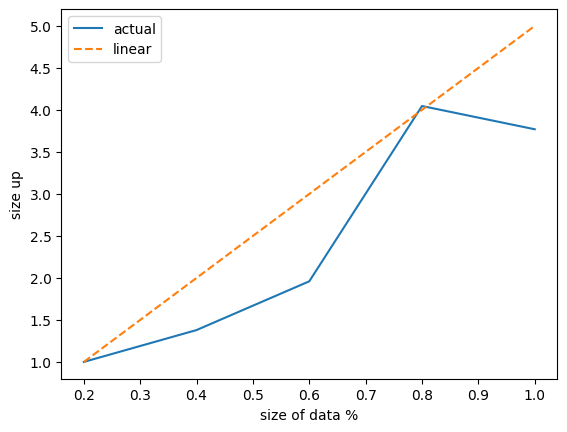

In [0]:
# May not be relicated
import matplotlib.pyplot as plt
plt.plot(sample_sizes, size_up, label= 'actual')
plt.plot(sample_sizes, linear_sizeup, linestyle='--', label = 'linear')
plt.xlabel("size of data %")
plt.ylabel("size up")
plt.legend()
plt.savefig("plots/sizeup.png")

# Predict labels for unlabelled data

In [0]:
# concatenating tokens
df_nolabel = df_nolabel.withColumn("tweet2", F.concat_ws(" ", "tokens"))
df_nolabel.show(5)

+--------------------+---------+-----+--------------------+
|              tokens|indicator|label|              tweet2|
+--------------------+---------+-----+--------------------+
|[love, cnn, well,...|        0|     |love cnn well des...|
|[know, someone, s...|        0|     |know someone seem...|
|[cdc, worry, mosq...|        0|     |cdc worry mosquit...|
|[sweat, place, it...|        0|     |sweat place it right|
|[kickoff, weekend...|        0|     |kickoff weekend g...|
+--------------------+---------+-----+--------------------+
only showing top 5 rows



In [0]:
# predicting labels for unlabelled set
df_predicted_label = df_nolabel.rdd.map(transform).toDF()


In [0]:
# Viewing results
df_predicted_label.show(5)

+--------------------+---------+-----+--------------------+----+
|              tokens|indicator|label|              tweet2|pred|
+--------------------+---------+-----+--------------------+----+
|[love, cnn, well,...|        0|     |love cnn well des...| 0.0|
|[know, someone, s...|        0|     |know someone seem...| 0.0|
|[cdc, worry, mosq...|        0|     |cdc worry mosquit...| 1.0|
|[sweat, place, it...|        0|     |sweat place it right| 2.0|
|[kickoff, weekend...|        0|     |kickoff weekend g...| 4.0|
+--------------------+---------+-----+--------------------+----+
only showing top 5 rows



### merge labelled and newly labelled data

In [0]:
# Check column names
df_train_labelled.columns

['tweet2', 'tokens', 'label', 'indicator', 'label_encoded']

In [0]:
# select some columns from df_predicted_label
df_predicted_label.columns
df_predicted_label = df_predicted_label.select(*['tweet2', 'tokens', 'label', 'indicator', 'pred']).withColumnRenamed(
    "pred", "label_encoded"
)

In [0]:
# Comparing column names between labelled and unlabelled sets
print(df_train_labelled.columns)
print(df_predicted_label.columns)

['tweet2', 'tokens', 'label', 'indicator', 'label_encoded']
['tweet2', 'tokens', 'label', 'indicator', 'label_encoded']


In [0]:
# Union labelled and newly labelled data
df_all_label = df_train_labelled.union(df_predicted_label)
df_all_label.show()

+--------------------+--------------------+------------------+---------+-------------+
|              tweet2|              tokens|             label|indicator|label_encoded|
+--------------------+--------------------+------------------+---------+-------------+
|realworld impact ...|[realworld, impac...|             other|        1|          0.0|
|steve job face up...|[steve, job, face...|          diseases|        1|          1.0|
|chubby doctor bad...|[chubby, doctor, ...|             other|        1|          0.0|
|diabetes gene com...|[diabetes, gene, ...|          diseases|        1|          1.0|
|underestimate chi...|[underestimate, c...|food and nutrition|        1|          2.0|
|way prep healthy ...|[way, prep, healt...|food and nutrition|        1|          2.0|
| way skinny new year|[way, skinny, new...|             other|        1|          0.0|
|nonprofit hospita...|[nonprofit, hospi...|           fitness|        1|          4.0|
|liberias prez wan...|[liberias, prez, ...|

### Retrain model with more labelled data

Attempts to repartition data fails here, setting a higher or lower number fails. WHY?

In [0]:
# get column names of the dataset
cols = df_all_label.columns

## Recreate the dataframe will all labelled data!!
- Surprised? Yes!!, this was done as a workaround of spark failure to repartion the dataframe
- We obtain an rdd for the dataframe and recreate it!!!.. repartitioning then works!!

In [0]:
# Train models for different number of partitions
# Recreating the dataframe, this may seem redundant but it is a work around because repartiting `df_all_label` was always failing
df_all_label2 = spark.createDataFrame(df_all_label.rdd, cols)

## Train model and record time

In [0]:
# caching leads to out of memory error, we deliberately not cache here
import time

# Loop through different number of partitions
min_partitions = 2
max_partitions = 5
partitions = (min_partitions, max_partitions + 1)

models_dict = {}
training_times = []
for p in range(*partitions):
    df_all_label3 = df_all_label2.repartition(p)
    start_time = time.time()  # record model training time - start
    models_ = df_all_label3.rdd.mapPartitions(train_model).collect()  # action
    end_time = time.time()
    training_time = end_time - start_time
    training_times.append(training_time)
    models_dict[p] = models_
    df_all_label3
print(training_times)

[1126.8971934318542, 103.47104668617249, 48.105034828186035, 44.02627992630005]


## Making predictions

In [0]:
# predict
predictions = {}
for p in range(*partitions):
    models = models_dict[p]
    predictions[p] = (
        df_test.rdd.map(transform)
        .toDF()
        .select("tweet2", "label", "label_encoded", "pred")
    )

predictions

{2: DataFrame[tweet2: string, label: string, label_encoded: double, pred: double],
 3: DataFrame[tweet2: string, label: string, label_encoded: double, pred: double],
 4: DataFrame[tweet2: string, label: string, label_encoded: double, pred: double],
 5: DataFrame[tweet2: string, label: string, label_encoded: double, pred: double]}

## Prediction evaluation

In [0]:
metrics = []
n_partition = []
for p in predictions.keys():
    n_partition.append(p)
    accuracy = evaluator.evaluate(predictions[p], {evaluator.metricName: "accuracy"})
    metrics.append(accuracy)
    print(f"Number of partitions {p}: Accuracy {accuracy}")

evaluation = pd.DataFrame(
    {
        "num_partitions": n_partition,
        "accuracy": metrics,
        "training_times": training_times,
    }
)

Number of partitions 2: Accuracy 0.7804919137466307
Number of partitions 3: Accuracy 0.7809973045822103
Number of partitions 4: Accuracy 0.7693733153638814
Number of partitions 5: Accuracy 0.7658355795148248


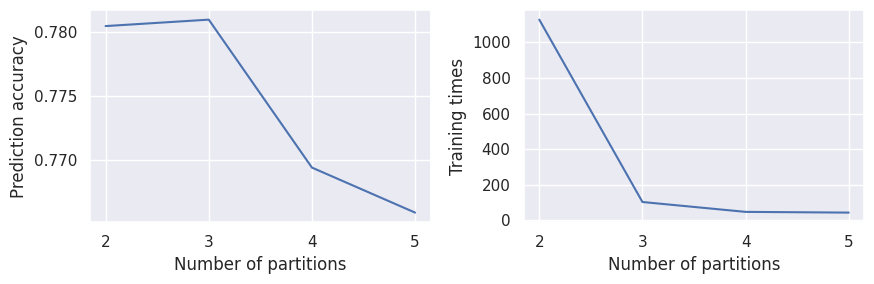

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set ggplot2 style
sns.set_theme()

fig, axs = plt.subplots(1, 2, figsize=(9, 3))

ax1 = axs[0]
ax1.plot(evaluation["num_partitions"], evaluation["accuracy"])
ax1.set_ylabel("Prediction accuracy")
ax1.set_xticks(evaluation["num_partitions"].astype(int))
ax1.set_xlabel("Number of partitions")

ax2 = axs[1]
ax2.plot(evaluation["num_partitions"], evaluation["training_times"])
ax2.set_ylabel("Training times")
ax2.set_xlabel("Number of partitions")

plt.xticks(evaluation["num_partitions"].astype(int))
plt.tight_layout()
plt.show()
fig.savefig("local_solution.png")


In [0]:
# Make a directory named "plots" in the workspace, if it doesn't already exist
!mkdir -p plots

# Save the figure in the "plots" directory
fig.savefig("plots/local_solution.png")

### Evaluate predictions

In [0]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="label_encoded", predictionCol="pred"
)

In [0]:
accuracy = evaluator.evaluate(predicted, {evaluator.metricName: "accuracy"})

recall = evaluator.evaluate(predicted, {evaluator.metricName: "weightedRecall"})

precision = evaluator.evaluate(predicted, {evaluator.metricName: "weightedPrecision"})

print("accuracy: ", accuracy)
print("recall: ", recall)
print("precision: ", precision)

accuracy:  0.8463611859838275
recall:  0.8463611859838276
precision:  0.8493149820433277


In [0]:
# df.unpersist()

## MLLIB IMPLEMENTATION: GLOBAL SEMI SUPERVISED

In [0]:
# Join Labelled and unlabelled sets so that we will only deal with one dataframe, unlabelled instances are labelled 99
df_nolabel2 = (
    df_nolabel.withColumn("label", F.lit(99))
    .withColumnRenamed("label", "label_encoded")
    .select(*["tokens", "indicator", "label_encoded"])
)

df_train_labelled2 = df_train_labelled.select(*["tokens", "indicator","label_encoded"])


df_all = df_nolabel2.union(df_train_labelled2)
df_all.show(3)

# df_all.cache()

+--------------------+---------+-------------+
|              tokens|indicator|label_encoded|
+--------------------+---------+-------------+
|[love, cnn, well,...|        0|         99.0|
|[know, someone, s...|        0|         99.0|
|[cdc, worry, mosq...|        0|         99.0|
+--------------------+---------+-------------+
only showing top 3 rows



In [0]:
# Get columns of the dataframe
cols = df_all.columns

In [0]:
df_all = spark.createDataFrame(df_all.rdd, cols)

In [0]:
df_all.persist()

DataFrame[tokens: array<string>, indicator: bigint, label_encoded: double]

In [0]:
# preprocess for training
# Import necessary libraries
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.classification import NaiveBayes




In [0]:

vectorizer = CountVectorizer(inputCol="tokens", outputCol="features")
vectorizer = vectorizer.fit(df_all)
# df_all_features = vectorizer.transform(df_all)


In [0]:
df_all_features = vectorizer.transform(df_all)

In [0]:
df_all_features.persist()
df.unpersist()

DataFrame[tokens: array<string>, indicator: int]

In [0]:
df_all_features.columns

['tokens', 'indicator', 'label_encoded', 'features']

In [0]:
# Create labelled and unlabelled data
df_labelled = df_all_features.filter(df_all_features.label_encoded!=99)

### Train base classifier

In [0]:
# Import necessary libraries
from pyspark.ml.classification import NaiveBayes

# Create a NaiveBayes classifier object
classifier = NaiveBayes(featuresCol="features", labelCol="label_encoded")

# Train the classifier on the features dataframe
model = classifier.fit(df_labelled)

### Evaluate base classifier

In [0]:
# Evaluate

# Tokenize the tweet2 column
tokenizer = Tokenizer(inputCol="tweet2", outputCol="tokens")


df_test = df_test.select(*["tweet2", "label_encoded"])
df_test_tokenized = tokenizer.transform(df_test)

df_test_features = vectorizer.transform(df_test_tokenized)
predicted = model.transform(df_test_features)

# # Evaluate the accuracy of the predictions
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="label_encoded", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predicted)

print(f"Base classifier accuracy {accuracy}")

Base classifier accuracy 0.8429919137466307


### predict unlabelled cases

In [0]:
import numpy as np
def class_distr(df, col2group):
  return np.array(
    df.groupBy(col2group).count().sort(col2group).toPandas()["count"], dtype="int"
  )

In [0]:
distr = class_distr(df_all_features.filter(df_all_features['label_encoded']!=99), 'label_encoded')

In [0]:
def instances_per_class(class_distrib,counts):
  ix_min = np.argmin(counts/distr)
  new_counts = counts[ix_min]*(distr/distr[ix_min])
  return np.round(new_counts).astype("int")

In [0]:
# modified from I. Triguero and M. Galar, Large-Scale Data Analytics with Python and Spark: A Hands-on Guide to Implementing Machine Learning Solutions. Cambridge University Press, 2023.

# self supervised training
from itertools import chain
from pyspark.ml.functions import vector_to_array

def self_training(data, max_iter=10, seed=2024, threshold=0.95, num_classes=6):

  nbc = NaiveBayes(featuresCol="features", labelCol="label_encoded")

  distr = class_distr(data.filter(data["label_encoded"]!=99),"label_encoded")

  for i in range(max_iter):
    labelled = data.filter("label_encoded!=99")
    print(f"Iteration {i} -- Labelled size {labelled.count()}")

    # Train classifier
    model = nbc.fit(labelled)
    
    # Predict and get probabilities
    preds = model.transform(data)
    # add prob columns
    preds = preds.withColumn('prob',F.array_max(vector_to_array("probability")))

    counts = class_distr(preds.filter((preds["label_encoded"]==99) & (preds["prob"] >= threshold)), "prediction")

    # conditions to terminate the loop
    if 0 in counts or len(counts) < num_classes:
      break

    to_add = instances_per_class(distr, counts)
    
    print(f"Adding {to_add[0]} instances from class 0")
    print(f"Adding {to_add[1]} instances from class 1")
    print(f"Adding {to_add[2]} instances from class 2")
    print(f"Adding {to_add[3]} instances from class 3")
    print(f"Adding {to_add[4]} instances from class 4")
    print(f"Adding {to_add[5]} instances from class 5")
  
    # Computing number of instances to be added
    pcts = to_add/counts
    map_pct = F.create_map([F.lit(x) for x in chain(*enumerate(pcts))])

    preds = preds.withColumn('pcts', map_pct[preds["prediction"]])
    preds = preds.withColumn("label_encoded", 
                                     F.when((preds["label_encoded"]==99)& (preds["prob"]>=threshold)
                                            &(F.rand(seed=2024) <= preds['pcts']),preds["prediction"]).otherwise(preds["label_encoded"])
                                    )
    
    data = preds.select("features", "label_encoded").persist()
  return data.filter("label_encoded != 99")






In [0]:
# Perform self supervised learning over different thresholds
# WARNING!!!! -- It may not be possible to replicate results for computation time
thresholds = [0.81,0.84, 0.87, 0.90, 0.93, 0.96, 0.99]
times = []
evaluations = []
instances_added = []
for t in thresholds:
  print(f"********THRESHOLD={t}*********")
  start_time = time.time()
  labelled_big = self_training(df_all_features, threshold=t)
  # labelled_big.persist() # cache
  model = classifier.fit(labelled_big)
  end_time = time.time()
  processing_time = end_time - start_time
  times.append(processing_time)

  size = labelled_big.count() - df_train_pd.shape[0]
  instances_added.append(size)

  model = classifier.fit(labelled_big)
  pred2 = model.transform(df_test_features)
  accuracy = evaluator.evaluate(pred2)
  evaluations.append(accuracy)
  labelled_big#.unpersist() # remove from cache
  print(f"SSL classifier accuracy {accuracy}")

********THRESHOLD=0.81*********
Iteration 0 -- Labelled size 23743
Adding 3718 instances from class 0
Adding 1951 instances from class 1
Adding 1626 instances from class 2
Adding 1071 instances from class 3
Adding 533 instances from class 4
Adding 393 instances from class 5
Iteration 1 -- Labelled size 32907
Adding 1095 instances from class 0
Adding 575 instances from class 1
Adding 479 instances from class 2
Adding 315 instances from class 3
Adding 157 instances from class 4
Adding 116 instances from class 5
Iteration 2 -- Labelled size 35635
Adding 293 instances from class 0
Adding 154 instances from class 1
Adding 128 instances from class 2
Adding 84 instances from class 3
Adding 42 instances from class 4
Adding 31 instances from class 5
Iteration 3 -- Labelled size 36341
Adding 70 instances from class 0
Adding 37 instances from class 1
Adding 31 instances from class 2
Adding 20 instances from class 3
Adding 10 instances from class 4
Adding 7 instances from class 5
Iteration 4 -- La

In [0]:
results = pd.DataFrame({'threshold':thresholds,'training time':times, 'accuracy':evaluations, 'instances added': instances_added})
results

,threshold,training time,accuracy,instances added
0,0.81,53.487681,0.795485,13800
1,0.84,92.015816,0.794137,12976
2,0.87,45.426701,0.794137,12299
3,0.90,40.988782,0.793801,10956
4,0.93,35.522616,0.802392,9463
5,0.96,41.258299,0.798518,8205
6,0.99,45.649768,0.811995,4203


---------------------------------------------------------------------------
Py4JJavaError                             Traceback (most recent call last)
File <command-4281566180897832>, line 53
     49 df = df.withColumn("tokens", lemmatize_word_udf(F.col("tokens")))
     52 df.persist()
---> 53 df.show(5)

File /databricks/spark/python/pyspark/instrumentation_utils.py:47, in _wrap_function.<locals>.wrapper(*args, **kwargs)
     45 start = time.perf_counter()
     46 try:
---> 47     res = func(*args, **kwargs)
     48     logger.log_success(
     49         module_name, class_name, function_name, time.perf_counter() - start, signature
     50     )
     51     return res

File /databricks/spark/python/pyspark/sql/dataframe.py:1061, in DataFrame.show(self, n, truncate, vertical)
    972 def show(self, n: int = 20, truncate: Union[bool, int] = True, vertical: bool = False) -> None:
    973     """
    974     Prints the first ``n`` rows of the DataFrame to the console.
    975 
   (...)


In [0]:
# Export results to latex 
import os
path = './table'


os.makedirs(path, exist_ok=True)

global_soln=results.to_latex(float_format='%.3f',index=True)

with open(os.path.join(path, 'global_soln.tex'),'w')  as f:
  f.write(global_soln)


---------------------------------------------------------------------------
Py4JJavaError                             Traceback (most recent call last)
File <command-4281566180897832>, line 53
     49 df = df.withColumn("tokens", lemmatize_word_udf(F.col("tokens")))
     52 df.persist()
---> 53 df.show(5)

File /databricks/spark/python/pyspark/instrumentation_utils.py:47, in _wrap_function.<locals>.wrapper(*args, **kwargs)
     45 start = time.perf_counter()
     46 try:
---> 47     res = func(*args, **kwargs)
     48     logger.log_success(
     49         module_name, class_name, function_name, time.perf_counter() - start, signature
     50     )
     51     return res

File /databricks/spark/python/pyspark/sql/dataframe.py:1061, in DataFrame.show(self, n, truncate, vertical)
    972 def show(self, n: int = 20, truncate: Union[bool, int] = True, vertical: bool = False) -> None:
    973     """
    974     Prints the first ``n`` rows of the DataFrame to the console.
    975 
   (...)


In [0]:
# model = classifier.fit(labelled_big)
# pred2 = model.transform(df_test_features)
# accuracy = evaluator.evaluate(pred2)
# print(f"SSL classifier accuracy {accuracy}")

---------------------------------------------------------------------------
Py4JJavaError                             Traceback (most recent call last)
File <command-4281566180897832>, line 53
     49 df = df.withColumn("tokens", lemmatize_word_udf(F.col("tokens")))
     52 df.persist()
---> 53 df.show(5)

File /databricks/spark/python/pyspark/instrumentation_utils.py:47, in _wrap_function.<locals>.wrapper(*args, **kwargs)
     45 start = time.perf_counter()
     46 try:
---> 47     res = func(*args, **kwargs)
     48     logger.log_success(
     49         module_name, class_name, function_name, time.perf_counter() - start, signature
     50     )
     51     return res

File /databricks/spark/python/pyspark/sql/dataframe.py:1061, in DataFrame.show(self, n, truncate, vertical)
    972 def show(self, n: int = 20, truncate: Union[bool, int] = True, vertical: bool = False) -> None:
    973     """
    974     Prints the first ``n`` rows of the DataFrame to the console.
    975 
   (...)
